In [1]:
# **********************************************************************************************************
# Author: Andi Sama
# Organization: Sinergi Wahana Gemilang
# Purpose: Demonstrate Quantum Transfer Learning
#          Doing Quantum Transfer Learning on trained resnet-18 model (Image Classification)
#          By retraining the final layer (fc-layer) on IBM Quantum Computer (simulator/real)
# Creation Date: June 21, 2020
# Changes history:
#   June 22, 2020
#     - initial test with ibm local quantum computer simulator
#   June 24-25, 2020
#     - provide options to select one of few backends for training (simulator, real quantum computer)
#   June 29, 2020
#     - test overall with bee & ants dataset
#     - add comments on code
#   June 30-July 1, 2020
#     - add & test new dataset: faces with mask, faces with no mask data 
#   July 2, 2020
#     - evaluate the expectation values (expval) on modified fc layer (quantum_net layer)
#         minus => first qubit measurement is not zero
#     - reformatting model output file name to include backend, num_epochs, datetime when generated
#     - add unique log file for each generated model
#   July 3-7, 2020
#     - documentation and start preparing for SWG Insight article
#     - add saving model for each epoch completion (epoch, train/val accuracy & loss)
#     - add graph, epoch vs train & val accuracy/loss
#   July 8, 2020
#     - 1st run, 30 epochs on x86 with IBMQ Simulator (local), with '_data/faces_google' dataset  
#         for SWG Insight Q1 2021 article    
#   July 14, 2020
#     -  add backend: google cirq
#
# To do:
#   ==> Test on IBM POWER AC922 (with V100 GPU)
#   ==> Generate final transfer learning models (min 10 epochs on _data/google for SWG Insight Q1 2021 article)
#       with Quantum Simulator / real Quantum Computer
#
# References:
#   code - https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html
#   code - https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
#   face mask/no_mask dataset - https://github.com/prajnasb/observations/tree/master/experiements/data
#
# See article in medium.com/@andisama (November 2020)
#
# **********************************************************************************************************

In [2]:
# The following illustration shows a generic base neural network model, Mp (Machine Learning model/ML-Model)
#   trained on ImageNet dataset (Da).
# The base model is then used as the base for Transfer Learning, on Image Classification task (based on resnet18)
# The last layer of this pre-trained model (fully-connected/fc layer, A2) is then modified (to be A2') by a quantum means.
#   through a quantum machine learning framework: Pennylane.ai with a new dataset (Db), generating a new model (Mrt).
# The Quantum ML framework (which is open-source) provides convenient access to multiple quantum simulator and
#   real quantum computer backend, including IBM real Quantum Computer on IBM Quantum Computing Experience
#   (IBM Cloud) through an open-source Qiskit API (Application Programming Interface) accessible
#   by Python programming language.

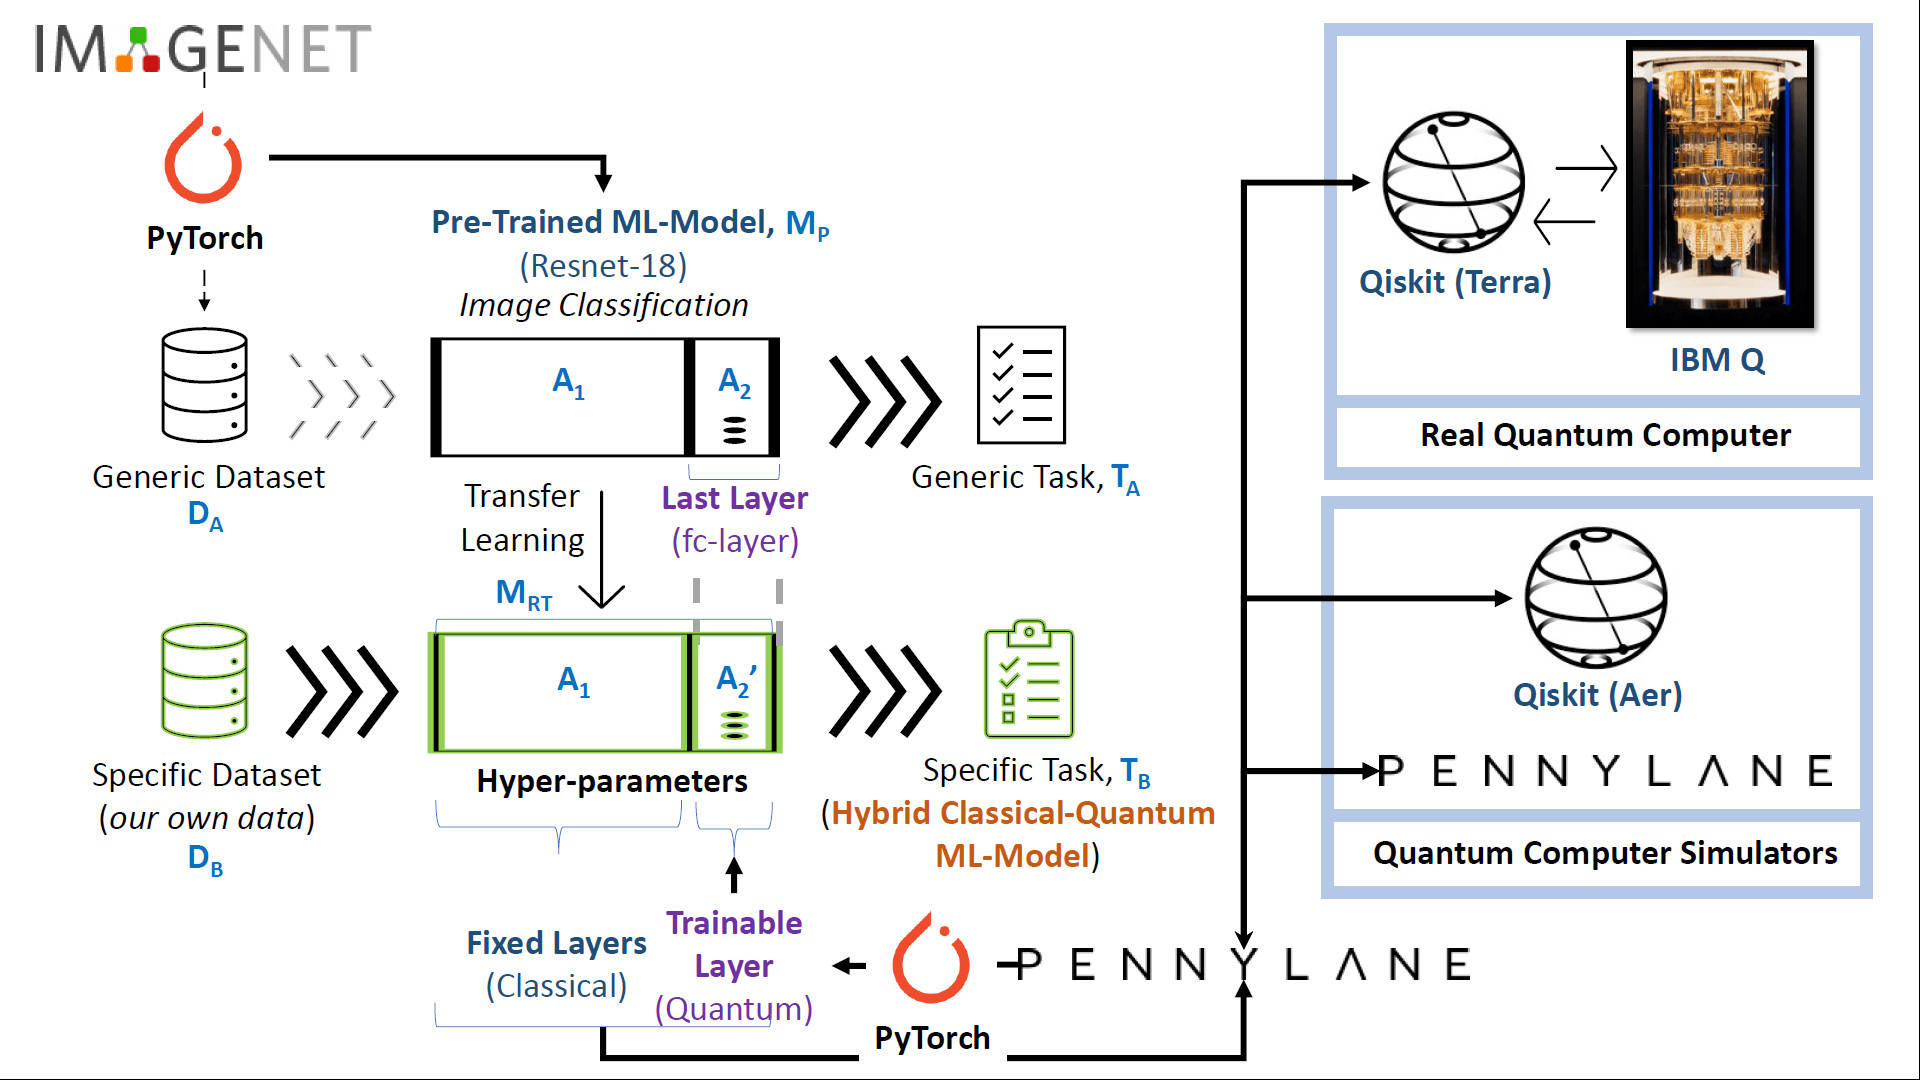

# 1. Preparation

## Load required Python libraries

In [3]:
# System
import time
import os, platform, sys
import copy
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

# ibm quantum computer
import qiskit
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

# tools
from asm_tools import myprint

In [4]:
print('[OS name]:', os.name, ', system:', platform.system(), \
      ', release:', platform.release(), ', system name:', platform.node())
print("[Python version]:", sys.version)
print("[Python version info]: ", sys.version_info)
print("[Deep Learning framework, Pytorch (Facebook) version]:", torch.__version__)
print("[Qiskit (IBM) version]:", qiskit.__version__)
print("[Quantum Machine Learning framework (Pennylane) version]:", qml.__version__)
print("[Anaconda version]:")
!conda list anaconda

[OS name]: nt , system: Windows , release: 10 , system name: ASM-T480
[Python version]: 3.7.7 (default, Mar 23 2020, 23:19:08) [MSC v.1916 64 bit (AMD64)]
[Python version info]:  sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
[Deep Learning framework, Pytorch (Facebook) version]: 1.5.1
[Qiskit (IBM) version]: 0.14.1
[Quantum Machine Learning framework (Pennylane) version]: 0.10.0
[Anaconda version]:
# packages in environment at C:\Users\andis\anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2019.03                  py37_0  
anaconda                  custom                   py37_1  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.12                   py37_0  
anaconda-project          0.8.4                      py_0  


## Create & Save IBM Token Credential to local computer

In [5]:
# -----------------------------------------------------------------------------
# just do this once - save your token to your computer to use later (IBMQ.load_account())
# get the token from your account in https://quantum-computing.ibm.com/
#  MyAccount -> Qiskit in local environment -> Copy Token
# IBMQ.save_account('your token here....') 

Hardware:
- CPU Configuration: Laptop CPU, Thinkpad T480, i7 cpu with 64GB RAM with SSD
- GPU Configuration: IBM POWER AC922 with NVidia V100 16GB GPU

#### A. Initial Testing: bees & ants (about 130 images training & validation)

During initial testing (2 categories, each category )
- Just for a quick go-through, set num_epochs = 1. ==> Training Accuracy will be about 60%
- around 7 min per epoch on CPU, batch size=8

If all things looks ok, num_epochs = 30 will produce quite a good result but may take some time to train on CPU
- around 3-4 hours for 30 epochs on CPU, batch size=8
- if high-end gpu is available, this should be around 1 hour

#### B. A new dataset for face mask & no mask (about 1500 images for training and validation, in _data/faces directory)

- 2 categories, each category about 750 for images training & validation
- Just for a quick go-through, set num_epochs = 1. ==> Training Accuracy will be about 93%
- around 45 min per epoch on CPU, batch size=8

If all things looks ok, num_epochs = 10 will produce quite a good result, but longer time to train on CPU 
- around 7 hours for 30 epochs on CPU, batch size=8
- if high-end gpu is available, this should be just about 2 hours


## Set Parameters

In [6]:
num_epochs = 30                     # Number of training epochs
dataset_dir = "_data/faces_google"  # quick train in "_data/faces", complete training data in "_data/faces_google"

n_qubits = 4                        # Number of qubits
step = 0.0004                       # Learning rate
batch_size = 8                      # Number of samples for each training step
q_depth = 6                         # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1            # Learning rate reduction applied every 10 epochs.
q_delta = 0.01                      # Initial spread of random quantum weights
rng_seed = 3                        # Seed for random number generator
start_time = time.time()            # Start of the computation timer

model_fileext = ".pth"
log_fileext = ".log" 

## Define Backend: Quantum Simulator or real Quantum Computer

In [7]:
def select_qc_backend():
    valid_selections = ('1', '2', '3', '5', '9')
    prompt = "Please select source:\n \
        1: Pennylane.ai Quantum Simulator\n \
        2: Qiskit Aer, IBM Quantum Simulator (local)\n \
        3: Qiskit IBMQ:Aer, IBM Quantum Simulator (IBM Quantum Computing Experience)\n \
        5: Google Cirq:Simulator (local)\n \
        9: Qiskit IBMQ:Terra, IBM real Quantum Computer (IBM Quantum Computing Experience)\n"    
    selection = input(prompt)
    while not(selection in valid_selections):
        selection = input(prompt)
    return selection

# select backend quantum computer
qc_backend = int(select_qc_backend())
if qc_backend == 1: # pennylane
    backend_name = "simPennylane"
    print("=> Using Pennylane Quantum Computer Simulator (local)")
    dev = qml.device("default.qubit", wires=n_qubits)
elif qc_backend == 2: # ibm quantum simulator (local) 
    backend_name = "simIBMQLocal"
    print("=> Using IBM Quantum Computer Simulator (local)")
    dev = qml.device("qiskit.aer", wires=n_qubits)
elif qc_backend == 3: # ibm quantum simulator (cloud) 
    backend_name = "simIBMQCloud"
    print("=> Using IBM Quantum Computer Simulator (IBM Quantum Computing Experience on IBM Cloud)")
    print("Loading IBMQ credentials...")
    IBMQ.load_account()
    provider = IBMQ.get_provider('ibm-q')
    backend = 'ibmq_qasm_simulator'
    dev = qml.device("qiskit.ibmq", wires=n_qubits, backend=backend)
    #dev.capabilities()['backend']
elif qc_backend == 5: # google quantum simulator (local) 
    backend_name = "simGoogleLocal"
    print("=> Using Google Quantum Computer Simulator (local)")
    dev = qml.device("cirq.simulator", wires=n_qubits)
elif qc_backend == 9: # ibm real quantum computer (cloud)
    backend_name = "realIBMQCloud"
    print("=> Using real IBM Quantum Computer (IBM Quantum Computing Experience on IBM Cloud)")
    print("Loading IBMQ credentials...")
    IBMQ.load_account()
    provider = IBMQ.get_provider('ibm-q')
    print("Searching available least busy real IBM Quantum Computer...")
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 \
        and not x.configuration().simulator \
        and x.status().operational==True))
    print('using least busy backend:', backend)
    dev = qml.device("qiskit.ibmq", wires=n_qubits, backend=str(backend))
    #dev.capabilities()['backend']

Please select source:
         1: Pennylane.ai Quantum Simulator
         2: Qiskit Aer, IBM Quantum Simulator (local)
         3: Qiskit IBMQ:Aer, IBM Quantum Simulator (IBM Quantum Computing Experience)
         5: Google Cirq:Simulator (local)
         9: Qiskit IBMQ:Terra, IBM real Quantum Computer (IBM Quantum Computing Experience)
1
=> Using Pennylane Quantum Computer Simulator (local)


In [8]:
now = datetime.now()
now_str = now.strftime("%d%m%Y%H%M%S")

# model & log file name to generate
# swgCQ_resnet18_ + selected backend name + max epochs + current date & time + extension
#   - pytorch model file extension '.pth'
#   - log file for the generated model file extension '.log'
base_filename = "swgCQ_"
interim_model_name = base_filename + backend_name 
hybrid_model_name = base_filename + backend_name + "(" + str(num_epochs) + ")-" + now_str + model_fileext
log_filename = base_filename + backend_name + "(" + str(num_epochs) + ")-" + now_str + log_fileext

train_val_filename = base_filename + backend_name + "_train_val-results" + now_str

message = "[Quantum Machine Learning for Image Classification]\n" \
    + "(Transfer Learning: base model is a pretrained resnet-18 (classical), then retrain the fc-layer (quantum) only)\n" \
    + "- @Andi Sama, 2020\n" \
    + "- Sinergi Wahana Gemilang\n" \
    + "- Tools: Python, QML:PennyLane.ai, Quantum Simulator & HW: IBM Q on Cloud, ML-Framework: Pytorch\n" \
    + "- Creating log file:" + now.strftime("%d/%m/%Y %H:%M:%S") + "\n" \
    + "- Target model name: " + hybrid_model_name + "\n" \
    + "- Selected quantum device backend: " + str(dev) + "\n"
myprint(log_filename, "new", message, screen=True)

[Quantum Machine Learning for Image Classification]
(Transfer Learning: base model is a pretrained resnet-18 (classical), then retrain the fc-layer (quantum) only)
- @Andi Sama, 2020
- Sinergi Wahana Gemilang
- Tools: Python, QML:PennyLane.ai, Quantum Simulator & HW: IBM Q on Cloud, ML-Framework: Pytorch
- Creating log file:14/07/2020 13:05:49
- Target model name: swgCQ_simPennylane(30)-14072020130549.pth
- Selected quantum device backend: Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.10.0
Author: Xanadu Inc.
Wires: 4
Shots: 1000



In [9]:
# USE NVidia CUDA (GPU) if available
# ----------------------------------
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")
if is_cuda_available:
    print ("cuda is available, using:", device)
else:
    print ("cuda is not available, using:", device)

message = "* Processing device: " + str(device)
myprint(log_filename, "append", message, screen=True)

cuda is not available, using: cpu
* Processing device: cpu


Note:

- The base dataset containing images of ants and bees can be downloaded from https://download.pytorch.org/tutorial/hymenoptera_data.zip and should be extracted in the subfolder _data/hymenoptera_data.
- Alternative dataset containing images of faces_with_nomask and faces_with_mask (google images search, about 100 each + data from https://github.com/prajnasb/observations/tree/master/experiements/data) are provided in the subfolder _data/faces. Total dataset each for mask & no_mask about 700 each for train/ directory, and 10% of it for val/ directory.

Note:
- For a quick test (training), to avoid long training time, set data directory to point to _data/faces_google with 1 epoch

## Prepare new dataset to retrain last layer (fc-layer) of pre-trained resnet-18

In [10]:
# initialize data loaders
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = dataset_dir # Images data, faces with and without mask
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

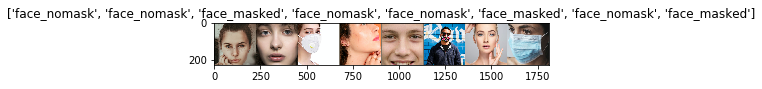

In [11]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# In order to get reproducible results, we set a manual seed for the
# random number generator and re-initialize the dataloaders.

torch.manual_seed(rng_seed)
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

## Define quantum layer to replace the fc-layer of pre-trained resnet-18

### Variational Quantum Circuit

#### Define base quantum layers
Define quantum layers that will compose the quantum circuit
- Hadamard (for making superposition)
- Ry & Entanglement

In [12]:
# 1st - Prepare the Quantum Gates
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
        
def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

#### Define Quantum Circuit
Define the quantum circuit through the PennyLane qnode decorator. The structure is that of a typical variational quantum circuit:
- Embedding layer: All qubits are first initialized in a balanced superposition of up and down states, then they are rotated according to the input parameters (local embedding).
- Variational layers: A sequence of trainable rotation layers and constant entangling layers is applied.
- Measurement layer: For each qubit, the local expectation value of the 
Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [13]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)
    
    # Embed features in the quantum node
    RY_layer(q_input_features)
    
    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])
        
    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

#### Define a custom torch.nn.Module representing a dressed quantum circuit.

This is a concatenation of:
- A classical pre-processing layer (nn.Linear)
- A classical activation function (torch.tanh)
- A constant np.pi/2.0 scaling
- The previously defined quantum circuit (quantum_net)
- A classical post-processing layer (nn.Linear)

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: face_mask and face_nomask).

In [14]:
# 2nd - Prepare the Replacement Quantum Layer
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

#### Build a full hybrid classical-quantum network

Following the transfer learning approach:

- load the classical pre-trained network ResNet18 from the torchvision.models zoo
- freeze all the weights since they should not be trained
- replace the last fully connected layer with our trainable dressed quantum circuit (DressedQuantumNet)

In [15]:
# 3rd - Replace last layer of resnet-18 with defined quantum layer
message = "* Loading pre-trained resnet-18..."
myprint(log_filename, "append", message, screen=True)
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

# Notice that model_hybrid.fc is the last layer of ResNet18
message = "  - Replacing last layer (fc-layer) with Quantum Layer..."
myprint(log_filename, "append", message, screen=True)
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

* Loading pre-trained resnet-18...
  - Replacing last layer (fc-layer) with Quantum Layer...


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

# 2. Retrain

## Define how to retrain the DressedQuantumNet (last layer)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, temp_model_name):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    message = "  => Training Started."
    myprint(log_filename, "append", message, screen=True)
    
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                message = "     > Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                                    phase,
                                    epoch + 1,
                                    num_epochs,
                                    it + 1,
                                    n_batches + 1,
                                    time.time() - since_batch,
                                 )
                # Print to file (not to screen)
                myprint(log_filename, "append", message, screen=False)
                # Print to screen with flush=True 
                print(message,
                        end="\r",
                        flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            message = "     > Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                                "train" if phase == "train" else "validation  ",
                                epoch + 1,
                                num_epochs,
                                epoch_loss,
                                epoch_acc,
                            )
            myprint(log_filename, "append", message, screen=True)

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            train_Acc = "{:.4f}".format(best_acc_train)
            train_Loss = "{:.4f}".format(best_loss_train)
            val_Acc = "{:.4f}".format(best_acc)
            val_Loss = "{:.4f}".format(best_loss)
            
            # Update learning rate
            if phase == "train":
                scheduler.step()
        
        # save the retrained model at this epoch completion
        # epoch is saved as epoch+1 (so to start at 1 instead of 0)
        # ---------------------------------------------------------
        model_at_epoch = temp_model_name + "-at-epoch-"+ str(epoch+1) \
            + "(" + str(num_epochs) + ")-" + now_str + model_fileext
        message = "* Saving interim model while training: " + model_at_epoch
        myprint(log_filename, "append", message, screen=True)
        torch.save(model_hybrid.state_dict(), model_at_epoch)
        
        # save results of trained model at this epoch
        # ------------------------------------------- 
        # append list of "epoch, train accuracy, train loss, val accuracy, val loss" per epoch completion
        #   accumulate in train_val_results
        if epoch==0:
            # create first row
            train_val_results = np.array([[epoch+1, best_acc_train, best_loss_train, best_acc, best_loss]])
            myprint(log_filename, "append", str(train_val_results), screen=True)
        else:
            train_result_at_epoch = np.array([[epoch+1, best_acc_train, best_loss_train, best_acc, best_loss]])
            # append new row
            train_val_results = np.append(train_val_results, train_result_at_epoch, axis=0) 
            myprint(log_filename, "append", str(train_result_at_epoch), screen=True)
        
    # Write train_val_results to file
    message = "* Saving train, val results (all epochs): 'epoch, best_acc_train, best_loss_train, best_acc, best_loss'"
    myprint(log_filename, "append", message, screen=True)
    np.save(train_val_filename, train_val_results)
    
    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    total_training_time = "{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    message = "  => Training completed in " + total_training_time
    total_training_time = "{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    myprint(log_filename, "append", message, screen=True)
    message = "  => Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc)
    myprint(log_filename, "append", message, screen=True)
    return model, total_training_time, train_Acc, train_Loss, val_Acc, val_Loss, train_val_results

## Re-train the quantum layer

In [18]:
message = "* (START re-training the Quantum Layer)"
myprint(log_filename, "append", message, screen=True)

# model_hybrid, total_training_time, train_Acc, train_Loss, val_Acc, val_Loss = train_model(
#     model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs, temp_model_name = interim_model_name
# )
model_hybrid, total_training_time, train_Acc, train_Loss, val_Acc, val_Loss, train_val_results = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs, temp_model_name = interim_model_name
)
message = "* (FINISH re-training the Quantum Layer)."
myprint(log_filename, "append", message, screen=True)

# for x in train_val_results:
#     print(x)

* (START re-training the Quantum Layer)
  => Training Started.
     > Phase: train Epoch: 1/30 Loss: 0.6161 Acc: 0.6792        
     > Phase: validation   Epoch: 1/30 Loss: 0.4813 Acc: 0.8400        
* Saving interim model while training: swgCQ_simPennylane-at-epoch-1(30)-14072020130549.pth
[[1.         0.67916667 0.61610194 0.84       0.48133923]]
     > Phase: train Epoch: 2/30 Loss: 0.4645 Acc: 0.8083        
     > Phase: validation   Epoch: 2/30 Loss: 0.3678 Acc: 0.9200        
* Saving interim model while training: swgCQ_simPennylane-at-epoch-2(30)-14072020130549.pth
[[2.         0.80833333 0.46448823 0.92       0.3678296 ]]
     > Phase: train Epoch: 3/30 Loss: 0.3749 Acc: 0.9125        
     > Phase: validation   Epoch: 3/30 Loss: 0.2851 Acc: 1.0000        
* Saving interim model while training: swgCQ_simPennylane-at-epoch-3(30)-14072020130549.pth
[[3.         0.9125     0.37490781 1.         0.28508855]]
     > Phase: train Epoch: 4/30 Loss: 0.3426 Acc: 0.9042        
     > P

     > Phase: train Epoch: 29/30 Loss: 0.2561 Acc: 0.9292        
     > Phase: validation   Epoch: 29/30 Loss: 0.1543 Acc: 1.0000        
* Saving interim model while training: swgCQ_simPennylane-at-epoch-29(30)-14072020130549.pth
[[29.          0.975       0.18618152  1.          0.14407798]]
     > Phase: train Epoch: 30/30 Loss: 0.1923 Acc: 0.9708        
     > Phase: validation   Epoch: 30/30 Loss: 0.1489 Acc: 1.0000        
* Saving interim model while training: swgCQ_simPennylane-at-epoch-30(30)-14072020130549.pth
[[30.          0.975       0.18618152  1.          0.14407798]]
* Saving train, val results (all epochs): 'epoch, best_acc_train, best_loss_train, best_acc, best_loss'
  => Training completed in 36m 59s
  => Best test loss: 0.1441 | Best test accuracy: 1.0000
* (FINISH re-training the Quantum Layer).


In [19]:
# SAVE final retrained Resnet-18 model
# ------------------------------------
message = "* Saving model:" + hybrid_model_name
myprint(log_filename, "append", message, screen=True)
torch.save(model_hybrid.state_dict(), hybrid_model_name)

* Saving model:swgCQ_simPennylane(30)-14072020130549.pth


In [20]:
# PRINT training summary
# ----------------------
from prettytable import PrettyTable
    
t_summary = PrettyTable()
t_summary.field_names = ["QC backend", "epoch", "batch size", \
    "train time", "train Acc", "train Loss", "val Acc", "val Loss"]
t_summary.add_row([backend_name, num_epochs, batch_size, \
    total_training_time, train_Acc, train_Loss, val_Acc, val_Loss])

message = "\n" 
myprint(log_filename, "append", message, screen=True)
message = "Training Summary for generated model: " + hybrid_model_name
myprint(log_filename, "append", message, screen=True)
message = str(datetime.now())
myprint(log_filename, "append", message, screen=True)
message = "Platform node: " + platform.node()
myprint(log_filename, "append", message, screen=True)
message = t_summary
myprint(log_filename, "append", t_summary, screen=True)



Training Summary for generated model: swgCQ_simPennylane(30)-14072020130549.pth
2020-07-14 13:42:50.636516
Platform node: ASM-T480
+--------------+-------+------------+------------+-----------+------------+---------+----------+
|  QC backend  | epoch | batch size | train time | train Acc | train Loss | val Acc | val Loss |
+--------------+-------+------------+------------+-----------+------------+---------+----------+
| simPennylane |   30  |     8      |  36m 59s   |   0.9750  |   0.1862   |  1.0000 |  0.1441  |
+--------------+-------+------------+------------+-----------+------------+---------+----------+


In [21]:
for x in train_val_results:
    print(x)

[1.         0.67916667 0.61610194 0.84       0.48133923]
[2.         0.80833333 0.46448823 0.92       0.3678296 ]
[3.         0.9125     0.37490781 1.         0.28508855]
[4.         0.9125     0.34261918 1.         0.26887998]
[5.         0.92916667 0.30498834 1.         0.25626792]
[6.         0.92916667 0.30498834 1.         0.20478087]
[7.         0.94583333 0.25953599 1.         0.18742863]
[8.         0.94583333 0.25953599 1.         0.18742863]
[9.         0.94583333 0.25953599 1.         0.16132949]
[10.          0.94583333  0.23698092  1.          0.14469663]
[11.          0.94583333  0.22893059  1.          0.14469663]
[12.          0.95        0.21090683  1.          0.14469663]
[13.          0.9625      0.20535207  1.          0.14469663]
[14.          0.9625      0.20474843  1.          0.14469663]
[15.          0.9625      0.20474843  1.          0.14469663]
[16.          0.9625      0.20474843  1.          0.14469663]
[17.          0.9625      0.20474843  1.          0.1

In [22]:
epoch = []
train_acc = []
train_loss = []
val_acc =[]
val_loss = []

for i in range(0, len(train_val_results)):
    epoch = np.append(epoch, train_val_results[i,0])
    train_acc = np.append(train_acc, train_val_results[i,1])
    train_loss = np.append(train_loss, train_val_results[i,2])    
    val_acc = np.append(val_acc, train_val_results[i,3])
    val_loss = np.append(val_loss, train_val_results[i,4])    
# print(epoch, "\n", train_acc, "\n", train_loss, "\n", val_acc, "\n", val_loss)

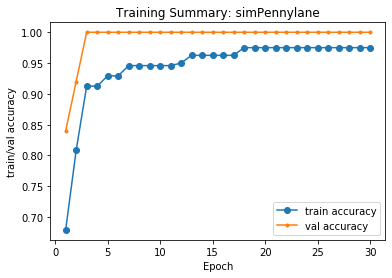

In [23]:
# PLOT graph - training/validation accuracy, loss
# -----------------------------------------------
x1 = epoch
x2 = epoch
y1 = train_acc
y2 = val_acc

# plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Training Summary: ' + backend_name)
plt.ylabel('train/val accuracy')

# plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Epoch')
# plt.ylabel('train/val accuracy')

plt.legend(["train accuracy","val accuracy"])
plt.show()

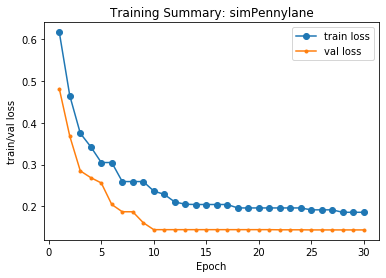

In [24]:
# PLOT graph - training/validation accuracy, loss
# -----------------------------------------------
y1 = train_loss
y2 = val_loss

# plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Training Summary: ' + backend_name)
plt.ylabel('train/val loss')

# plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Epoch')
# plt.ylabel('train/val loss')

plt.legend(["train loss","val loss"])
plt.show()

In [25]:
# INSPECT the retrained Resnet-18 model neural network architecture
# -----------------------------------------------------------------
model_arch = model_hybrid.eval()

message = "[The modified neural network architecture]\n" + str(model_arch)
myprint(log_filename, "append", message, screen=True)

[The modified neural network architecture]
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# 3. Test/Predict using the re-trained model

In [26]:
def visualize_model(model, num_images=4, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name, figsize=(15,15))
    model.eval()
    with torch.no_grad(): # inferencing
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # Expectation value is probabilistic expected value of the result (measurement) of an experiment
            # Pennylane implements the quantum measurement in such a way that:
            #  - if the first qubit is non zero, it puts negative to the measurement
            # expvals is expectation value of predicted class
            expvals, preds = torch.max(outputs, 1)
            # expvals_min is expectation value of another class as we only have 2 image classes/categories here
            expvals_min, preds_min = torch.min(outputs, 1)
            #print("input size:", type(inputs), inputs.size())
            #print("expvals max", expvals, "\npreds max", preds, "\nexpvals min", expvals_min, "\npreds min", preds_min)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                title = "Detected as <" + class_names[preds[j]] + ">, Expectation Value: " + \
                    "{:.5f}".format(expvals[j]) + " (" + \
                    "{:.5f}".format(expvals_min[j]) + ")" 
                ax.set_title("[{}]".format(title))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

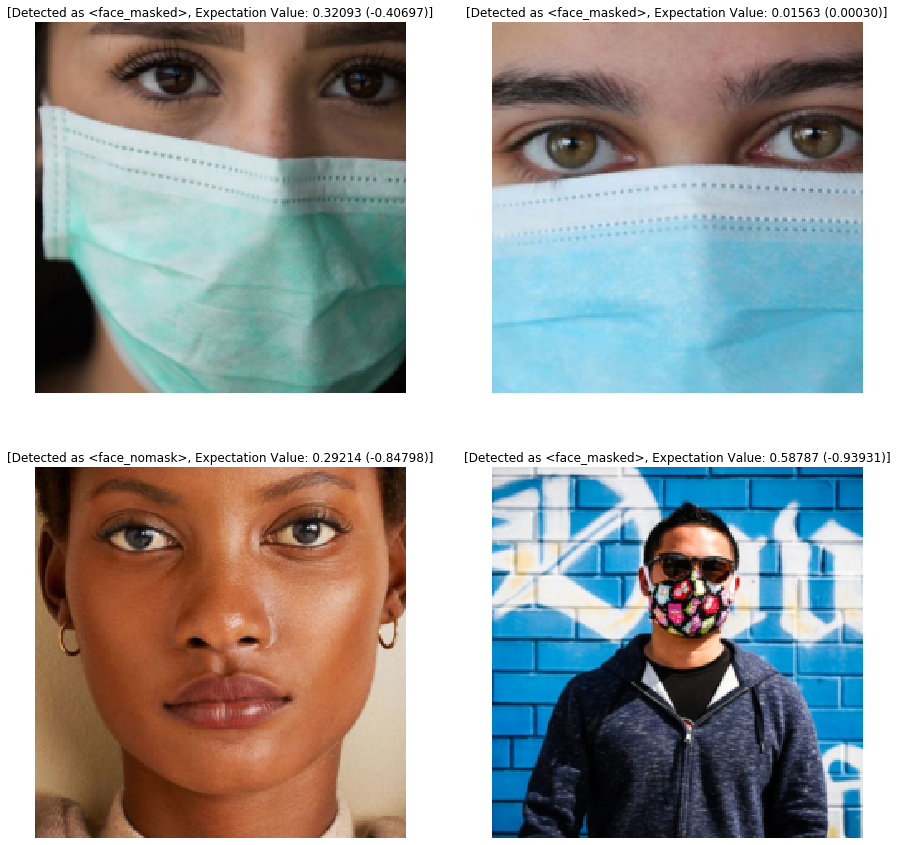

In [27]:
visualize_model(model_hybrid, num_images=4)
plt.show()

# Side Note - Independent Inferencing
## Independently use "Hybrid Classical-Quantum Image Classification model" 

### Prepare

In [28]:
import os, platform, sys

# PyTorch
import torch
import torch.nn as nn
#import torch.optim as optim
#from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

# qml parameters
n_qubits = 4                # Number of qubits
batch_size = 8              # Number of samples for each training step
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01              # Initial spread of random quantum weights

In [29]:
# USE NVidia CUDA (GPU) if available
# ----------------------------------
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")
if is_cuda_available:
    print ("cuda is available, using:", device)
else:
    print ("cuda is not available, using:", device)   

cuda is not available, using: cpu


In [30]:
# First, need to have all codes that are defined in

#  - "Define Backend: Quantum Simulator or real Quantum Computer" (to get 'dev' variable) above
#     ==> can be set manually, e.g. for IBM local Quantum Simulator
dev = qml.device("qiskit.aer", wires=n_qubits)

#  - "Define quantum layer to replace the fc-layer of pre-trained resnet-18" above
#  - "Prepare new dataset to retrain last layer (fc-layer) of pre-trained resnet-18" => "initialize data loaders" section only
#  - "Test/Predict using the re-trained model" above

### Load the pre-trained hybrid Classical-Quantum model

In [31]:
# A. prepare
# replace my_hybrid_model_name with your chosen model name when running inference separately
my_hybrid_model_name = hybrid_model_name
# - load pre-trained resnet-18 model
my_model_hybrid = torchvision.models.resnet18(pretrained=True)
for param in my_model_hybrid.parameters():
    param.requires_grad = False
# - replace the last layer. notice that model_hybrid.fc is the last layer of ResNet18
my_model_hybrid.fc = DressedQuantumNet()
# - use CUDA or CPU according to the "device" object.
my_model_hybrid = my_model_hybrid.to(device)

# B. load our hybrid trained model
my_model = my_model_hybrid
my_model.load_state_dict(torch.load(my_hybrid_model_name))

<All keys matched successfully>

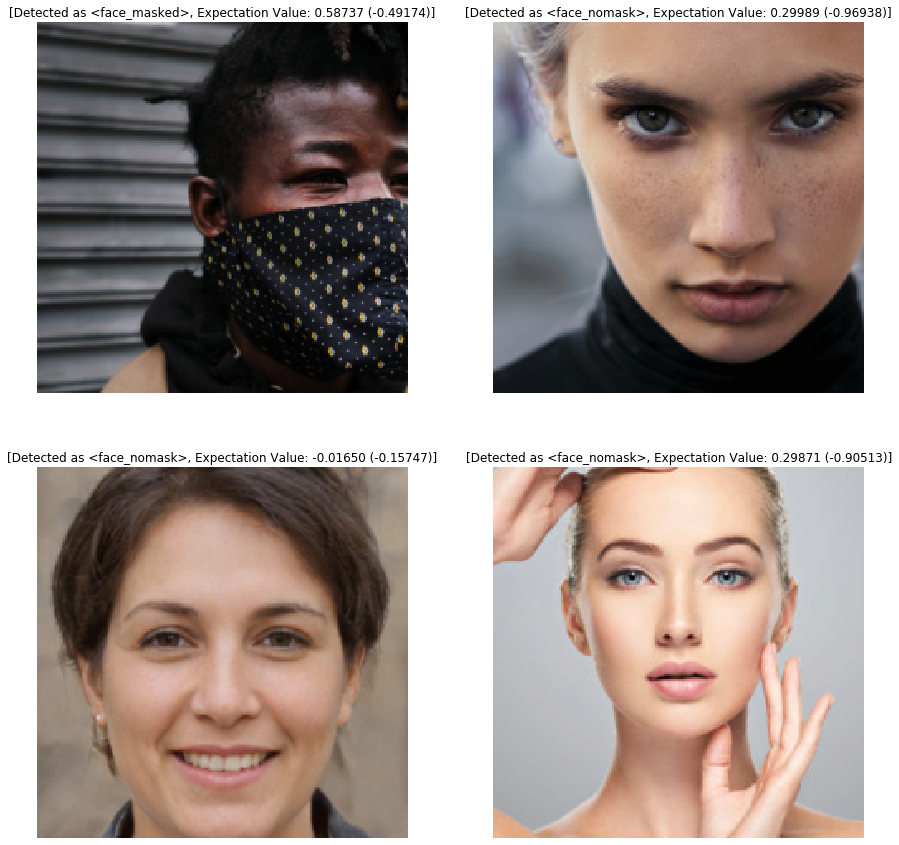

In [32]:
# then, test (batch of images)
visualize_model(my_model, num_images=4)
plt.show()

In [33]:
# then, test (single image)
# visualize_single_image(my_model, img_name="image.jpg")
# plt.show()